<img src="statics/iguide_logo.png" width=200 height=200 />

# National Water Model (WRFHydro) - Community Hydrological Modelling support on I-GUIDE platform

The [I-GUIDE](https://iguide.illinois.edu/) project is extending and enhancing cyberinfrastructure that enables [National Water Model (NWM)](https://water.noaa.gov/about/nwm) data products to be configured and used to address specific questions related to water availability, flood prediction, and inundation mapping. The NWM is an implementation of the Weather Research and Forecasting Model Hydrological modeling system ([WRF-Hydro](https://ncar.ucar.edu/)) at continental-scale. The cyberinfrastructure and workflows needed to implement, set up and configure the data product subsets for a modeling domain of interest are complex, and demand a high level of skill from researchers, thus limiting broad applicability. I-GUIDE is building on modeling capability developed by the [HydroShare](https://www.hydroshare.org/), [CyberGISX](https://cybergisxhub.cigi.illinois.edu/) and other projects enabling computing for the hydrology community and integrating data connectors and processors from the [GeoEDF](https://github.com/geoedf) project to deploy simple to use workflows for setting up and running WRF-Hydro configured like the NWM for any watershed specified in the US NWM modeling domain.

This notebook demostrates the setup for a typical WRFHydro model on I-GUIDE platform leveraging different tools or services through out the entire end-to-end modelling workflow illustrated below.

<center><img src="statics/wrfhydro-workflow.png" width=600 height=400 /></center>

In [30]:
import os # allows us to communicate with the operating system
import time # this module provides various time-related functions
from datetime import datetime, timedelta # to specify the time domain for analysis
import shutil # this module offers a number of high-level operations on files and collections of files
import requests # request module lets us make request to web pages
import xarray as xr #xarray makes it easier to work with multidimensional datasets like the NWM forecasts.
import matplotlib.pyplot as plt  # helps to create plots.

## Setup Simulation Parameters

In [52]:
# huc12 id
# huc12 = "070200030503"
huc12 = "160102030302"  # huc 12 to identify the spatial domain of interest
# huc12 = "160102030301"
# Start at 00:00 (12AM)
start_datetime = datetime(2016, 1, 1)     # specify the simulation start time  (Year, Month, Day)
#                          Y   M   D
# End at 00:00 (12AM)
end_datetime = datetime(2016, 1, 7)     # specify the simulation end time  (Year, Month, Day)
#                        Y   M   D

# version WRFHydro codebase on github (tag/release/commit id)
wrfhydro_version = "v5.2.0"  

## Map Layout

This map layout represents the Logan River Watershed. For this example, we have selected the upstream watershed (the highlighted one)

<img src="statics//Layout.jpg" width=400 height=300 />

In [53]:
params_subset_domain = {"huc12_id": huc12, 
                        "start_date": start_datetime.strftime("%m/%d/%Y"), 
                        "end_date": end_datetime.strftime("%m/%d/%Y")}
params_subset_domain

{'huc12_id': '160102030302',
 'start_date': '01/01/2016',
 'end_date': '01/07/2016'}

## Subset DOMAIN Files with GeoEDF Data Connector on CyberGIS Compute

The source of WRFHydro DOMAIN files is [CUAHSI Domain Subsetter](https://subset.cuahsi.org/) service. I-GUIDE provides a reusable [GeoEDF Data Connector](https://dl.acm.org/doi/10.1145/3311790.3396631) ([CUAHSISubsetterInput-Connector](https://github.com/I-GUIDE/cybergis-compute-cuahsisubsetterinput-connector) ) that makes requests to CUAHSI Domain Subsetter REST APIs and retrieves the domain files ready for model use. The GeoEDF Data Connector has been integrated into [CyberGIS-Compute](https://cybergis.github.io/cybergis-compute-python-sdk/reference.html) as a job that can be invoked by users from Jupyter environment and executed on supported HPC resources. The subset domain files staged remotely is ready for use by WRFHydro model on HPC, and user has the option to download the files from HPC back to Jupyter for local manipulation.

In [54]:
import cybergis_compute_client
from cybergis_compute_client import CyberGISCompute

cybergis = CyberGISCompute(url="cgjobsup.cigi.illinois.edu", isJupyter=True, protocol="HTTPS", port=443, suffix="v2")
cybergis.show_ui(defaultJob="CUAHSI_Subsetter_Connector", input_params=params_subset_domain)

Make sure to download the output and then continueRetain Domain Subsetter JobID for later reference

In [55]:
jobid_cuahsi_subset_domain = cybergis.job.id
jobid_cuahsi_subset_domain

'1662148316evEVL'

## Subset FORCINGS with GeoEDF Data Processor on CyberGIS Compute

The source of WRFHydro FORCING files is [AORC](https://registry.opendata.aws/nwm-archive/) dataset hosted on AWS. I-GUIDE provides a reusable [GeoEDF Data Processor](https://dl.acm.org/doi/10.1145/3311790.3396631) ([SubsetForcingData-Processor](https://github.com/I-GUIDE/cybergis-compute-subsetaorcforcingdata-processor) ) that subsets forcing files spatially and temporally. This GeoEDF Data Processor has been integrated into [CyberGIS-Compute](https://cybergis.github.io/cybergis-compute-python-sdk/reference.html) as a job that can be invoked by users from Jupyter environment and executed on supported HPC resources. The subset forcing files staged remotely is ready for use by WRFHydro model on HPC, and user has the option to download the files from HPC back to Jupyter for local manipulation.

In [56]:
import cybergis_compute_client
from cybergis_compute_client import CyberGISCompute

cybergis = CyberGISCompute(url="cgjobsup.cigi.illinois.edu", isJupyter=True, protocol="HTTPS", port=443, suffix="v2")
cybergis.show_ui(defaultJob="Subset_AORC_Forcing_Data_Processor", input_params=params_subset_domain)

Retain Forcing Processor JobID for later reference

In [57]:
jobid_subset_forcing = cybergis.job.id
jobid_subset_forcing

'1662148833iohwA'

## Prepare Model Configurations

In [8]:
# setEnvar.sh ---> SPATIAL_SOIL=1 export HYDRO_D=1

In [59]:
# Create a "Simulation" directory

workspace = os.getcwd()

simulation_dir = os.path.join(workspace, 'Simulation')
if os.path.exists(simulation_dir):
    shutil.rmtree(simulation_dir)
os.makedirs(simulation_dir)

#List of files
os.listdir(simulation_dir)

[]

In [60]:
! wget https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/setEnvar.sh
! sed -i '/export HYDRO_D=0/c\export HYDRO_D=1' ./setEnvar.sh
! sed -i '/export SPATIAL_SOIL=0/c\export SPATIAL_SOIL=1' ./setEnvar.sh
! cat ./setEnvar.sh | grep -E 'HYDRO_D|SPATIAL_SOIL'
! mv ./setEnvar.sh {simulation_dir}

--2022-09-02 20:01:48--  https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/setEnvar.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 532 [text/plain]
Saving to: ‘setEnvar.sh’

setEnvar.sh         100%[===================>]     532  --.-KB/s    in 0s      

2022-09-02 20:01:48 (29.6 MB/s) - ‘setEnvar.sh’ saved [532/532]

export HYDRO_D=1
export SPATIAL_SOIL=1


In [61]:
# namelist.hrldas --> START_YEAR START_MONTH START_DAY START_HOUR START_MIN RESTART_FILENAME_REQUESTED
start_year = start_datetime.year
start_month = "{:02d}".format(start_datetime.month)
start_day = "{:02d}".format(start_datetime.day)
start_hour = "{:02d}".format(start_datetime.hour)
start_minute = "{:02d}".format(start_datetime.minute)
khour = (end_datetime - start_datetime) / timedelta(hours=1)
khour = "{}".format(int(khour))

In [62]:
! rm -rf namelist.hrldas
! wget https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/NoahMP/namelist.hrldas
! sed -i  '/HRLDAS_SETUP_FILE/c\HRLDAS_SETUP_FILE = "./DOMAIN/wrfinput_d0x.nc"' ./namelist.hrldas
! sed -i  '/START_YEAR/c\START_YEAR = '"$start_year" ./namelist.hrldas
! sed -i  '/START_MONTH/c\START_MONTH = '"$start_month" ./namelist.hrldas
! sed -i  '/START_DAY/c\START_DAY = '"$start_day" ./namelist.hrldas
! sed -i  '/START_HOUR/c\START_HOUR = '"$start_hour" ./namelist.hrldas
! sed -i  '/START_MIN/c\START_MIN = '"$start_minute" ./namelist.hrldas
! sed -i  '/KHOUR =/c\KHOUR = '"$khour" ./namelist.hrldas
! sed -i  '/RESTART_FILENAME_REQUESTED/c\!RESTART_FILENAME_REQUESTED = ""' ./namelist.hrldas
! cat ./namelist.hrldas | grep -E 'HRLDAS_SETUP_FILE|START_|KHOUR'
! mv ./namelist.hrldas {simulation_dir}

--2022-09-02 20:01:56--  https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/NoahMP/namelist.hrldas
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2425 (2.4K) [text/plain]
Saving to: ‘namelist.hrldas’

namelist.hrldas     100%[===================>]   2.37K  --.-KB/s    in 0s      

2022-09-02 20:01:56 (47.2 MB/s) - ‘namelist.hrldas’ saved [2425/2425]

HRLDAS_SETUP_FILE = "./DOMAIN/wrfinput_d0x.nc"
START_YEAR = 2016
START_MONTH = 01
START_DAY = 01
START_HOUR = 00
START_MIN = 00
!RESTART_FILENAME_REQUESTED = ""
KHOUR = 144
RESTART_FREQUENCY_HOURS = 24


In [63]:
# hydro.namelist  --> RESTART_FILE
! rm -rf hydro.namelist
! wget https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/HYDRO/hydro.namelist
! sed -i '/GEO_STATIC_FLNM/c\GEO_STATIC_FLNM = "./DOMAIN/geo_em.d0x.nc"' ./hydro.namelist
! sed -i '/RESTART_FILE/c\!RESTART_FILE = ""' ./hydro.namelist
! sed -i  '/GW_RESTART/c\GW_RESTART = 0' ./hydro.namelist
! sed -i  '/LSMOUT_DOMAIN/c\LSMOUT_DOMAIN = 1' ./hydro.namelist
! sed -i  '/output_gw/c\output_gw = 1' ./hydro.namelist
! sed -i '/outlake/c\outlake  = 0' ./hydro.namelist
! sed -i '/output_gw/c\output_gw  = 0' ./hydro.namelist
! sed -i '/GWBASESWCRT/c\GWBASESWCRT  = 1' ./hydro.namelist
! sed -i '/output_channelBucket_influx/c\output_channelBucket_influx  = 2' ./hydro.namelist
! sed -i '/channel_option/c\channel_option  = 2' ./hydro.namelist
! sed -i '/route_link_f/c\route_link_f  = "./DOMAIN/Route_Link.nc"' ./hydro.namelist
! sed -i '/compound_channel/c\!compound_channel  = .FALSE.' ./hydro.namelist
! sed -i '/route_lake_f/c\!route_lake_f  = "./DOMAIN/LAKEPARM.nc"' ./hydro.namelist
! sed -i '/gwbasmskfil/c\!gwbasmskfil  = "./DOMAIN/GWBASINS.nc"' ./hydro.namelist
! sed -i '/UDMP_OPT/c\UDMP_OPT  = 1' ./hydro.namelist
! sed -i '/!udmap_file/c\udmap_file = "./DOMAIN/spatialweights.nc"' ./hydro.namelist
! cat hydro.namelist | grep -E "RESTART|outlake|GWBASESWCRT|route_lake_f|gwbasmskfil"
! mv ./hydro.namelist {simulation_dir}

--2022-09-02 20:02:02--  https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/HYDRO/hydro.namelist
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11277 (11K) [text/plain]
Saving to: ‘hydro.namelist’

hydro.namelist      100%[===================>]  11.01K  --.-KB/s    in 0s      

2022-09-02 20:02:02 (141 MB/s) - ‘hydro.namelist’ saved [11277/11277]

!RESTART_FILE = ""
GW_RESTART = 0
outlake  = 0
!route_lake_f  = "./DOMAIN/LAKEPARM.nc"
GWBASESWCRT  = 1
!gwbasmskfil  = "./DOMAIN/GWBASINS.nc"


## Run WRFHydro Model on HPC with CyberGIS Compute

In [64]:
params_wrfhydro = {"Model_Version": wrfhydro_version,
                   "LSM_Type": "NoahMP",
                   "Forcing_Path": jobid_subset_forcing,
                   "Domain_Path": jobid_cuahsi_subset_domain,
                   "Merge_Output": "True"}
params_wrfhydro

{'Model_Version': 'v5.2.0',
 'LSM_Type': 'NoahMP',
 'Forcing_Path': '1662148833iohwA',
 'Domain_Path': '1662148316evEVL',
 'Merge_Output': 'True'}

In [65]:
import cybergis_compute_client
from cybergis_compute_client import CyberGISCompute

cybergis = CyberGISCompute(url="cgjobsup.cigi.illinois.edu", isJupyter=True, protocol="HTTPS", port=443, suffix="v2")
cybergis.create_job_by_ui(defaultJob="wrfhydro-5.x", defaultDataFolder=simulation_dir,input_params=params_wrfhydro)

Download only the Outputs_Merged/CHRTOUT folder and retain WRFHydro JobID

In [66]:
jobid_wrfhydro = cybergis.job.id
output_wrfhydro = cybergis.recentDownloadPath
!ls -LR {output_wrfhydro}

/home/jovyan/globus_download_16621489405eSZS:
CHRTOUT_DOMAIN1_merged.nc


## Data Visualization

In [67]:
# path of the merged file of channel routing "CHRTOUT_DOMAIN1_merged.nc"
ch_file = '{}/CHRTOUT_DOMAIN1_merged.nc'.format(output_wrfhydro)
print(ch_file)
# path of the route link "Rouet_Link.nc"
routelink ='/home/jovyan/globus_download_{}/Route_Link.nc'.format(jobid_cuahsi_subset_domain)
print(routelink)

# convert rouetlink to dataframe
route_df = xr.open_dataset(routelink).to_dataframe() # convert routelink to dataframe
route_df.gages = route_df.gages.str.decode('utf-8').str.strip()
route_df # print out the routelink dataframe

# Re-name the "Route_Link.nc" variables
cols = ['order', 'link', 'gages', 'lat', 'lon', 'to', 'from']  # columns name of original routelink dataframe
route_re_df = route_df[cols].sort_values(by=['order'])      # reduce the size of routelink dataframe to include only these columns ['order', 'link', 'gages', 'lat', 'lon', 'to', 'from']

# rename the columns
route_renm_df = route_re_df.rename(index=str, columns={"order": "stream_order",
                                       "link": "comid",
                                       "from": 'upstream_comid',
                                       'to':'downstream_comid',
                                       "gages": 'usgs_gageid',
                                       "lat": 'lat-midpoint',
                                       "lon": 'lon-midpoint'})
route_renm_df.reset_index(inplace=True)
# data.drop('linkDim', axis=1, inplace=True)

########################################################################
########################################################################
# Load channel routing data "CHRTOUT_DOMAIN1_merged.nc"
channel_ds = xr.open_dataset(ch_file)
########################################################################
########################################################################

# Reduce the size of the dataset to only the essential variables.
reach_ds = channel_ds
reach_ds = reach_ds[['streamflow',        # Streamflow 
                     'q_lateral',         # lateral inflow through reach
                     'qSfcLatRunoff',     # runoff from terrain routing
                     'qBucket',           # flux from groundwater (gw) bucket
                     'qBtmVertRunoff',    # runoff from bottom of soil to bucket
                     'order',
                     'velocity',
                     'Head',
                     'elevation']]

## clean unnecessary data
reach_ds = reach_ds.reset_coords()
reach_ds = reach_ds.drop(labels=['latitude','longitude'])
reach_ds.attrs = {}

route_renm_df

/home/jovyan/globus_download_16621489405eSZS/CHRTOUT_DOMAIN1_merged.nc
/home/jovyan/globus_download_1662148316evEVL/Route_Link.nc


,feature_id,stream_order,comid,usgs_gageid,lat-midpoint,lon-midpoint,downstream_comid,upstream_comid
0,0,1,661278,,42.069935,-111.614906,661280,0
1,122,1,664098,,41.961823,-111.589806,664110,0
2,124,1,664104,,41.960060,-111.589516,664108,0
3,126,1,664108,,41.959370,-111.589195,664122,0
4,53,1,661292,,42.046421,-111.560333,661298,0
...,...,...,...,...,...,...,...,...
131,134,4,664162,,41.898247,-111.565254,664168,0
132,131,4,664148,,41.917816,-111.563545,664152,0
133,132,4,664152,,41.909115,-111.563324,664156,0
134,133,4,664156,,41.905579,-111.563744,664162,0


The next cell shows all the National Water Model (NWM)  reaches. Please click on the reach of interest that is located within your selected watershed domain

In [68]:
%%HTML
<html>
<head></head>
<body>
<iframe title="NWM Reaches" src="https://byu-hydroinformatics.github.io/csb-jr233/" width=900 height=600>
</iframe>
</body>
</html>

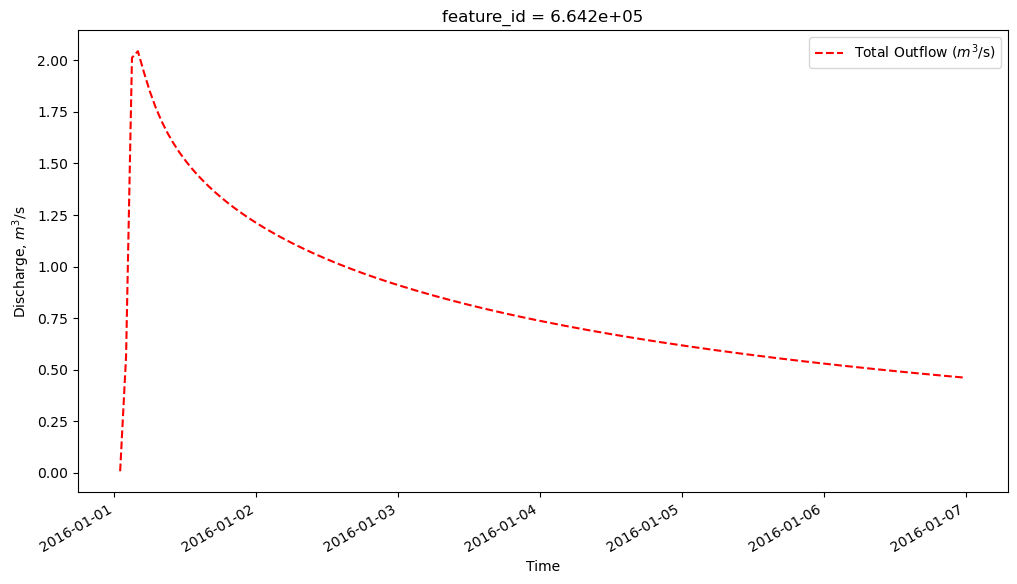

In [69]:
import matplotlib.pyplot as plt
reachid= 664168

fig, ax = plt.subplots(1, 1, figsize=(12,6), sharex='col')

reach_ds.sel(feature_id=reachid)['streamflow'].plot(ax=ax,
                                                    label='Total Outflow ($m^3$/s)',
                                                    color='red',
                                                    linestyle='--')
# plot settings
plt.ylabel('Discharge, $m^3$/s')
plt.xlabel("Time")
# plt.title("")
plt.legend(loc="upper right")
plt.savefig('Hydrograph.png')

## The End